In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os.path

In [46]:
ticker = "TNA"

In [47]:
def getDB(ticker):
    tick = ticker
    # Load data
    data = yf.Ticker(tick)
    df = data.history(period="5y", interval="1d")
#     df = data.history(start="2018-12-01", end="2020-03-01")
#     start="2017-01-01", end="2017-04-30"
    
    # add data points
    df['close_per1'] = df.ta.percent_return(1)*100
    df['sma10'] = df.ta.sma(length=10)
    df['williams'] = df.ta.willr()


    df = df[[
            'open','close','sma10','williams','close_per1'
            ]]

    df = df.dropna()
    
    return df

In [48]:
data = getDB(ticker)
print(data['close_per1'].std())
print(data.head(5))
print(data.tail(5))

4.448215298951527
                 open      close      sma10   williams  close_per1
date                                                              
2017-01-23  48.812677  48.649506  49.949431 -85.270657   -1.135450
2017-01-24  49.163738  50.775665  50.048322 -47.116249    4.370362
2017-01-25  52.031582  52.328255  50.155618 -16.129111    3.057743
2017-01-26  52.348033  51.715126  50.177868 -19.549714   -1.171697
2017-01-27  51.764578  51.111897  50.261432 -32.036797   -1.166447
                 open      close      sma10   williams  close_per1
date                                                              
2021-12-27  84.500000  86.599998  79.254777 -14.188268    2.850358
2021-12-28  86.199997  85.029999  79.934092 -22.320079   -1.812933
2021-12-29  84.889999  85.260002  80.845266 -17.004946    0.270497
2021-12-30  85.180000  85.139999  81.375690 -17.658998   -0.140749
2021-12-31  84.550003  85.010002  82.389777 -18.367524   -0.152686


In [12]:
data.iloc[1]
data.index[0]

Timestamp('2017-01-23 00:00:00')

In [58]:
def set_data(ticker):
    df = getDB(ticker)

    df['CP_ol'] = 0 # open to close day percentage [classify by 0,1,2]
    df['CO_il'] = 0 # close(i) to open(i+1) price [classify by 0,1]
    df['SMA10_il'] = 0 # sma(10 day) compared to close price (i)
    df['W_il'] = 0 # Williams [classify by -1,0,1]
    
    value = df['close_per1'].std()
    
    # setting the outputs in the df
    for i in range(len(df)):
        if df.iloc[i]['close_per1'] > value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 2
        elif df.iloc[i]['close_per1'] < -value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 1
        else:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 0
    
    # setting the inputs in the df
    for i in range(len(df)-1):
#         try:
#         print("close data:",df.index[i])
#         print("open data:",df.index[i+1])
#         print("putting data here:",df.index[i+1])
#         print()
        if df.iloc[i]['close'] < df.iloc[i+1]['open']:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = 1
        else:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = 0
#         except:
#             df.iloc[i+1, df.columns.get_loc('CO_il')] = np.nan
            
    
#     # setting the inputs in the df
#     for i in range(len(df)):
#         try:
#             if df.iloc[i]['close'] > df.iloc[i]['sma10']:
#                 df.iloc[i, df.columns.get_loc('SMA10_il')] = 1
#             else:
#                 df.iloc[i, df.columns.get_loc('SMA10_il')] = 0
#         except:
#             df.iloc[i, df.columns.get_loc('SMA10_il')] = np.nan
       
    # setting the inputs in the df
    for i in range(len(df)-1):
#         try:
        if df.iloc[i+1]['open'] > df.iloc[i]['sma10']:
            df.iloc[i+1, df.columns.get_loc('SMA10_il')] = 1
        else:
            df.iloc[i+1, df.columns.get_loc('SMA10_il')] = 0
#         except:
#             df.iloc[i+1, df.columns.get_loc('SMA10_il')] = np.nan
    
    
    # setting the inputs in the df
    for i in range(len(df)):
        if df.iloc[i]['williams'] > -30: # overbought
            df.iloc[i, df.columns.get_loc('W_il')] = -1
        elif df.iloc[i]['williams'] < -70: # oversold
            df.iloc[i, df.columns.get_loc('W_il')] = 1
        else:
            df.iloc[i, df.columns.get_loc('W_il')] = 0 # neutral
    
    df['W_il'] = df.W_il.shift(1)
#     df['SMA10_il'] = df.SMA10_il.shift(1)
    
    # deleting data that is not normalized
    del df['open']
    del df['close']
    del df['sma10']
    del df['williams']
#     del df['close_per1']
    
    # reformating
    df = df[[
            'W_il','SMA10_il','CO_il','CP_ol','close_per1'
            ]]
    
    df = df.dropna()
    
    return df

In [59]:
df = set_data(ticker)
print(df.head())

            W_il  SMA10_il  CO_il  CP_ol  close_per1
date                                                
2017-01-24   1.0         0      1      0    4.370354
2017-01-25   0.0         1      1      0    3.057758
2017-01-26  -1.0         1      1      0   -1.171690
2017-01-27  -1.0         1      1      0   -1.166469
2017-01-30   0.0         0      0      0   -3.976005


In [60]:
A = []
# setting the outputs in the df
for i in range(len(df)):
    if df.iloc[i]['CO_il'] == 1:
        if 
        A.append(df.iloc[i]['close_per1'])
a = np.average(A)
print(a)

1.5161695727160296


In [51]:
def process_train(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[0:-SHIFT]
        
        del df['close_per1']

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")



In [52]:
def process_test(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        
        del df['close_per1']

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")

In [53]:
SEQ_LEN = 3  # how long of a preceeding sequence to collect for RNN
# FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
SHIFT = 150  # how far to shift the data so it can be back testest
BATCH_SIZE = 64 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
EPOCHS = 750 # how many passes through our data


tickers_train = [ticker]
tickers_test = [ticker]

train_x, train_y = process_train(tickers_train, SEQ_LEN,SHIFT)
validation_x, validation_y = process_test(tickers_test, SEQ_LEN, SHIFT)

In [54]:
print(train_x[0])
print('training data length: %d' % (len(train_x)))
print('validation data length: %d' % (len(validation_x)))

[[1. 0. 1.]
 [0. 0. 1.]
 [0. 1. 1.]]
training data length: 315
validation data length: 42


In [55]:
## Building the RNN ##
print()
print("length of train data: ", len(train_x))
print("length of validation data: ", len(validation_x))
print()

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

print()
print()

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()


length of train data:  315
length of validation data:  42

Epoch 1/750
5/5 [==============================] - 3s 148ms/step - loss: 1.1403 - accuracy: 0.3714 - val_loss: 1.0992 - val_accuracy: 0.2381
Epoch 2/750
5/5 [==============================] - 0s 9ms/step - loss: 1.1385 - accuracy: 0.3905 - val_loss: 1.0991 - val_accuracy: 0.3810
Epoch 3/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1308 - accuracy: 0.3651 - val_loss: 1.0990 - val_accuracy: 0.3810
Epoch 4/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1254 - accuracy: 0.3841 - val_loss: 1.0989 - val_accuracy: 0.4048
Epoch 5/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1240 - accuracy: 0.3587 - val_loss: 1.0988 - val_accuracy: 0.4048
Epoch 6/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1175 - accuracy: 0.3778 - val_loss: 1.0986 - val_accuracy: 0.4286
Epoch 7/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1042 - accuracy: 0.4095 - 

5/5 [==============================] - 0s 9ms/step - loss: 1.0289 - accuracy: 0.4571 - val_loss: 1.0768 - val_accuracy: 0.5476
Epoch 60/750
5/5 [==============================] - 0s 9ms/step - loss: 1.0166 - accuracy: 0.4730 - val_loss: 1.0756 - val_accuracy: 0.5476
Epoch 61/750
5/5 [==============================] - 0s 9ms/step - loss: 1.0278 - accuracy: 0.4571 - val_loss: 1.0745 - val_accuracy: 0.5476
Epoch 62/750
5/5 [==============================] - 0s 9ms/step - loss: 1.0197 - accuracy: 0.4603 - val_loss: 1.0733 - val_accuracy: 0.5476
Epoch 63/750
5/5 [==============================] - 0s 9ms/step - loss: 1.0158 - accuracy: 0.4635 - val_loss: 1.0722 - val_accuracy: 0.5476
Epoch 64/750
5/5 [==============================] - 0s 8ms/step - loss: 1.0271 - accuracy: 0.4444 - val_loss: 1.0709 - val_accuracy: 0.5476
Epoch 65/750
5/5 [==============================] - 0s 9ms/step - loss: 1.0206 - accuracy: 0.4762 - val_loss: 1.0696 - val_accuracy: 0.5476
Epoch 66/750
5/5 [===============

5/5 [==============================] - 0s 9ms/step - loss: 0.9897 - accuracy: 0.5238 - val_loss: 0.9755 - val_accuracy: 0.5952
Epoch 118/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9905 - accuracy: 0.5016 - val_loss: 0.9751 - val_accuracy: 0.5952
Epoch 119/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9860 - accuracy: 0.5111 - val_loss: 0.9745 - val_accuracy: 0.5952
Epoch 120/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9925 - accuracy: 0.4952 - val_loss: 0.9736 - val_accuracy: 0.5952
Epoch 121/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9906 - accuracy: 0.4921 - val_loss: 0.9728 - val_accuracy: 0.5952
Epoch 122/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9895 - accuracy: 0.5016 - val_loss: 0.9727 - val_accuracy: 0.5952
Epoch 123/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9883 - accuracy: 0.5270 - val_loss: 0.9718 - val_accuracy: 0.5714
Epoch 124/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.9582 - accuracy: 0.5333 - val_loss: 0.9642 - val_accuracy: 0.5238
Epoch 176/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9560 - accuracy: 0.5238 - val_loss: 0.9637 - val_accuracy: 0.5238
Epoch 177/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9559 - accuracy: 0.5206 - val_loss: 0.9636 - val_accuracy: 0.5238
Epoch 178/750
5/5 [==============================] - 0s 11ms/step - loss: 0.9615 - accuracy: 0.5016 - val_loss: 0.9632 - val_accuracy: 0.5238
Epoch 179/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9523 - accuracy: 0.5270 - val_loss: 0.9635 - val_accuracy: 0.5238
Epoch 180/750
5/5 [==============================] - 0s 10ms/step - loss: 0.9606 - accuracy: 0.5429 - val_loss: 0.9638 - val_accuracy: 0.5238
Epoch 181/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9703 - accuracy: 0.5397 - val_loss: 0.9637 - val_accuracy: 0.5238
Epoch 182/750
5/5 [======

5/5 [==============================] - 0s 9ms/step - loss: 0.9392 - accuracy: 0.5238 - val_loss: 0.9591 - val_accuracy: 0.5238
Epoch 234/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9382 - accuracy: 0.5333 - val_loss: 0.9581 - val_accuracy: 0.5238
Epoch 235/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9410 - accuracy: 0.5524 - val_loss: 0.9589 - val_accuracy: 0.5238
Epoch 236/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9273 - accuracy: 0.5429 - val_loss: 0.9583 - val_accuracy: 0.5238
Epoch 237/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9382 - accuracy: 0.5333 - val_loss: 0.9577 - val_accuracy: 0.5238
Epoch 238/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9291 - accuracy: 0.5397 - val_loss: 0.9577 - val_accuracy: 0.5238
Epoch 239/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9344 - accuracy: 0.5175 - val_loss: 0.9580 - val_accuracy: 0.5238
Epoch 240/750
5/5 [========

5/5 [==============================] - 0s 10ms/step - loss: 0.9131 - accuracy: 0.5778 - val_loss: 0.9546 - val_accuracy: 0.5476
Epoch 292/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9104 - accuracy: 0.5683 - val_loss: 0.9546 - val_accuracy: 0.5476
Epoch 293/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9096 - accuracy: 0.5683 - val_loss: 0.9551 - val_accuracy: 0.5476
Epoch 294/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9037 - accuracy: 0.5810 - val_loss: 0.9553 - val_accuracy: 0.5476
Epoch 295/750
5/5 [==============================] - 0s 10ms/step - loss: 0.9042 - accuracy: 0.5873 - val_loss: 0.9548 - val_accuracy: 0.5476
Epoch 296/750
5/5 [==============================] - 0s 9ms/step - loss: 0.9182 - accuracy: 0.5778 - val_loss: 0.9548 - val_accuracy: 0.5476
Epoch 297/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9070 - accuracy: 0.5524 - val_loss: 0.9548 - val_accuracy: 0.5476
Epoch 298/750
5/5 [======

5/5 [==============================] - 0s 9ms/step - loss: 0.8969 - accuracy: 0.5778 - val_loss: 0.9503 - val_accuracy: 0.5238
Epoch 350/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8938 - accuracy: 0.5873 - val_loss: 0.9502 - val_accuracy: 0.5238
Epoch 351/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8908 - accuracy: 0.5714 - val_loss: 0.9504 - val_accuracy: 0.5238
Epoch 352/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8919 - accuracy: 0.5841 - val_loss: 0.9507 - val_accuracy: 0.5238
Epoch 353/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8863 - accuracy: 0.5937 - val_loss: 0.9506 - val_accuracy: 0.5238
Epoch 354/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8897 - accuracy: 0.5873 - val_loss: 0.9502 - val_accuracy: 0.5476
Epoch 355/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8940 - accuracy: 0.5841 - val_loss: 0.9501 - val_accuracy: 0.5476
Epoch 356/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.8786 - accuracy: 0.6032 - val_loss: 0.9471 - val_accuracy: 0.5238
Epoch 408/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8825 - accuracy: 0.5619 - val_loss: 0.9468 - val_accuracy: 0.5238
Epoch 409/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8797 - accuracy: 0.5683 - val_loss: 0.9469 - val_accuracy: 0.5476
Epoch 410/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8734 - accuracy: 0.5778 - val_loss: 0.9477 - val_accuracy: 0.5238
Epoch 411/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8674 - accuracy: 0.5968 - val_loss: 0.9477 - val_accuracy: 0.5476
Epoch 412/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8817 - accuracy: 0.5810 - val_loss: 0.9474 - val_accuracy: 0.5476
Epoch 413/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8721 - accuracy: 0.5905 - val_loss: 0.9472 - val_accuracy: 0.5238
Epoch 414/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.8602 - accuracy: 0.6095 - val_loss: 0.9466 - val_accuracy: 0.5238
Epoch 466/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8665 - accuracy: 0.5841 - val_loss: 0.9464 - val_accuracy: 0.5238
Epoch 467/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8598 - accuracy: 0.5873 - val_loss: 0.9465 - val_accuracy: 0.5238
Epoch 468/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8726 - accuracy: 0.5841 - val_loss: 0.9469 - val_accuracy: 0.5238
Epoch 469/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8587 - accuracy: 0.5937 - val_loss: 0.9463 - val_accuracy: 0.5238
Epoch 470/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8634 - accuracy: 0.5968 - val_loss: 0.9454 - val_accuracy: 0.5238
Epoch 471/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8642 - accuracy: 0.6317 - val_loss: 0.9453 - val_accuracy: 0.5476
Epoch 472/750
5/5 [========

5/5 [==============================] - 0s 10ms/step - loss: 0.8532 - accuracy: 0.5937 - val_loss: 0.9475 - val_accuracy: 0.5238
Epoch 524/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8536 - accuracy: 0.6032 - val_loss: 0.9481 - val_accuracy: 0.5238
Epoch 525/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8431 - accuracy: 0.6254 - val_loss: 0.9473 - val_accuracy: 0.5238
Epoch 526/750
5/5 [==============================] - 0s 10ms/step - loss: 0.8446 - accuracy: 0.6032 - val_loss: 0.9469 - val_accuracy: 0.5238
Epoch 527/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8518 - accuracy: 0.6000 - val_loss: 0.9469 - val_accuracy: 0.5238
Epoch 528/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8434 - accuracy: 0.6381 - val_loss: 0.9474 - val_accuracy: 0.5238
Epoch 529/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8419 - accuracy: 0.6032 - val_loss: 0.9470 - val_accuracy: 0.5238
Epoch 530/750
5/5 [======

5/5 [==============================] - 0s 9ms/step - loss: 0.8393 - accuracy: 0.6095 - val_loss: 0.9496 - val_accuracy: 0.5000
Epoch 582/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8301 - accuracy: 0.6063 - val_loss: 0.9495 - val_accuracy: 0.5000
Epoch 583/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8388 - accuracy: 0.6000 - val_loss: 0.9500 - val_accuracy: 0.5000
Epoch 584/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8434 - accuracy: 0.6032 - val_loss: 0.9497 - val_accuracy: 0.5000
Epoch 585/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8407 - accuracy: 0.6127 - val_loss: 0.9496 - val_accuracy: 0.5000
Epoch 586/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8368 - accuracy: 0.6190 - val_loss: 0.9501 - val_accuracy: 0.5000
Epoch 587/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8473 - accuracy: 0.6190 - val_loss: 0.9499 - val_accuracy: 0.5000
Epoch 588/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.8323 - accuracy: 0.6349 - val_loss: 0.9518 - val_accuracy: 0.5238
Epoch 640/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8308 - accuracy: 0.6222 - val_loss: 0.9518 - val_accuracy: 0.5238
Epoch 641/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8312 - accuracy: 0.6063 - val_loss: 0.9514 - val_accuracy: 0.5238
Epoch 642/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8321 - accuracy: 0.6032 - val_loss: 0.9511 - val_accuracy: 0.5238
Epoch 643/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8307 - accuracy: 0.6063 - val_loss: 0.9509 - val_accuracy: 0.5238
Epoch 644/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8237 - accuracy: 0.6349 - val_loss: 0.9496 - val_accuracy: 0.5238
Epoch 645/750
5/5 [==============================] - 0s 10ms/step - loss: 0.8319 - accuracy: 0.5968 - val_loss: 0.9495 - val_accuracy: 0.5238
Epoch 646/750
5/5 [=======

5/5 [==============================] - 0s 9ms/step - loss: 0.8162 - accuracy: 0.6190 - val_loss: 0.9520 - val_accuracy: 0.5238
Epoch 698/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8249 - accuracy: 0.6286 - val_loss: 0.9518 - val_accuracy: 0.5238
Epoch 699/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8261 - accuracy: 0.6222 - val_loss: 0.9516 - val_accuracy: 0.5238
Epoch 700/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8302 - accuracy: 0.6032 - val_loss: 0.9522 - val_accuracy: 0.5238
Epoch 701/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8264 - accuracy: 0.5937 - val_loss: 0.9526 - val_accuracy: 0.5238
Epoch 702/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8197 - accuracy: 0.6349 - val_loss: 0.9518 - val_accuracy: 0.5238
Epoch 703/750
5/5 [==============================] - 0s 9ms/step - loss: 0.8218 - accuracy: 0.6159 - val_loss: 0.9525 - val_accuracy: 0.5238
Epoch 704/750
5/5 [========

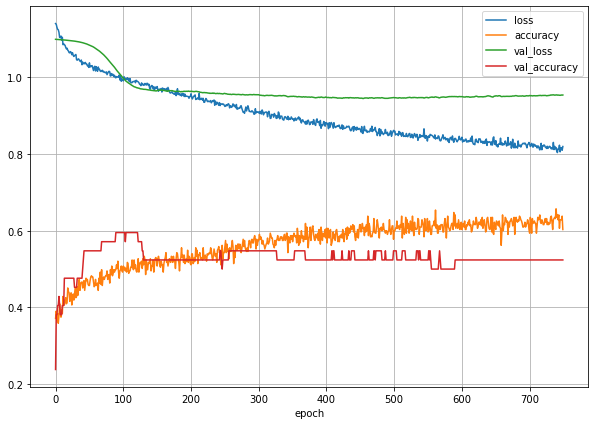

Test loss: 0.9539925456047058
Test accuracy: 0.523809552192688


In [56]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('epoch')
plt.grid()
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [37]:
def process_test_buys(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!
        
        Sequential_data = Sequential_data + sequential_data
        
    X = []; y = []; z = []
    for seq, target, actual in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        z.append(actual)

    return np.array(X).astype("float64"), np.array(y).astype("uint8"), np.array(z).astype("float64")

In [38]:
last_trading_days = 100
test_x, test_y, test_z = process_test_buys(tickers_test, SEQ_LEN, last_trading_days)

In [39]:
output = model.predict(test_x)

In [40]:
results = []; total = 0
for i, j in zip(output, test_z):
    if np.argmax(i) == 2:
        total += 1
#         results.append([i,j])
        results.append(j)

In [41]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 1.623460 percent, over 33 trades.
You started with $5000 and finished with $8276 after 33 trades.


In [42]:
print(results)

[5.025056559514063, 5.726489588815231, 2.945719141125891, 2.0142415174281503, -2.9965008400013704, -3.8817195659787362, 0.6445998637189643, 4.458672335756675, 5.388521343106012, 4.3221755332707, 1.0774372730292692, 4.736963722489929, -2.3522654959157174, -1.733972163156594, 1.3039937046066319, 4.332835651170441, 1.0787321744884615, 2.9126285555452602, 7.7005575108721525, -0.1503032817136929, -1.2771784113766782, -1.2791909238900834, -0.6247845791248041, -6.820156418592194, 8.209351729204517, -6.248460619411134, 6.049490496665411, 6.840351822165136, 2.2420054420520197, -0.8734705143035981, -6.221057960005282, 8.627715496969547, 2.3957114324287376]


In [43]:
results = []; total = 0
for i, j in zip(output, test_z):
    if i[2] > 0.6:
        total += 1
#         results.append([i,j])
        results.append(j)

In [44]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 1.147891 percent, over 13 trades.
You started with $5000 and finished with $5702 after 13 trades.


In [45]:
print(results)

[5.025056559514063, 5.726489588815231, 0.6445998637189643, 5.388521343106012, 4.736963722489929, -1.2791909238900834, -0.6247845791248041, -6.820156418592194, -6.248460619411134, 6.840351822165136, -0.8734705143035981, -6.221057960005282, 8.627715496969547]


model.summary()

In [ ]:
# model.get_weights()

In [ ]:

if os.path.isfile('FAS_model.h5') is False:
    model.save('FAS_model.h5')


In [ ]:
model1 = load_model('FAS_model.h5')

In [ ]:
model1.summary()